In [13]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
def get_data_loader(file, features, features_to_encode):
    df = pd.read_csv(file)
    df["Episode_Title"] = df["Episode_Title"].str[8:]
    y = df[["Listening_Time_minutes"]]
    df = df[features]
    imputer = SimpleImputer(strategy="median")
    df[["Episode_Length_minutes"]] = imputer.fit_transform(df[["Episode_Length_minutes"]])
    df[["Guest_Popularity_percentage"]] = imputer.fit_transform(df[["Guest_Popularity_percentage"]])
    df[["Number_of_Ads"]] = imputer.fit_transform(df[["Number_of_Ads"]])
    df["Is_Weekend"] = (df["Publication_Day"] == "Saturday") | (df["Publication_Day"] == "Sunday")
    def one_hot(df, feature):
        encoded = pd.get_dummies(df[[feature]])
        result = pd.concat([df, encoded], axis=1)
        result = result.drop([feature], axis=1)
        return(result) 
    for to_encode in features_to_encode:
        df = one_hot(df, to_encode)
    df["Ads_Per_Minute"] = df['Number_of_Ads'] / df["Episode_Length_minutes"]
    df["People_Popularity"] = df["Host_Popularity_percentage"] + df["Guest_Popularity_percentage"]
    df["Linear"] = df["Episode_Length_minutes"] * 0.728

    x = df
    x = x.to_numpy().astype(np.float32)
    y = y.to_numpy().astype(np.float32)
    return x, y

features=["Episode_Length_minutes", "Number_of_Ads", "Host_Popularity_percentage", "Guest_Popularity_percentage",
          "Episode_Sentiment", "Publication_Day", "Publication_Time", "Genre", "Podcast_Name"]
features_to_encode = ["Episode_Sentiment", "Publication_Day", "Publication_Time",  "Genre", "Podcast_Name"]
x, y = get_data_loader("train.csv", 
    features=features,
    features_to_encode=features_to_encode )

In [38]:
'''
model = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=3200,
    max_depth=6,
    learning_rate=0.375,
    max_bin = 100,
    verbosity=0,
    eval_metric='rmse'
)
'''

model = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=3200,
    max_depth=7,
    learning_rate=0.5,
    max_bin = 100,
    verbosity=0,
    eval_metric='rmse'
)

model.fit(
    x, y,
    eval_set = [(x, y)],
    verbose = True,
) 

[0]	validation_0-rmse:17.76511
[1]	validation_0-rmse:14.47741
[2]	validation_0-rmse:13.51565
[3]	validation_0-rmse:13.24771
[4]	validation_0-rmse:13.16607
[5]	validation_0-rmse:13.13571
[6]	validation_0-rmse:13.11652
[7]	validation_0-rmse:13.09971
[8]	validation_0-rmse:13.09116
[9]	validation_0-rmse:13.07686
[10]	validation_0-rmse:13.06661
[11]	validation_0-rmse:13.05983
[12]	validation_0-rmse:13.04968
[13]	validation_0-rmse:13.04237
[14]	validation_0-rmse:13.03182
[15]	validation_0-rmse:13.02729
[16]	validation_0-rmse:13.02085
[17]	validation_0-rmse:13.01364
[18]	validation_0-rmse:13.00634
[19]	validation_0-rmse:12.99592
[20]	validation_0-rmse:12.98625
[21]	validation_0-rmse:12.97814
[22]	validation_0-rmse:12.97202
[23]	validation_0-rmse:12.96587
[24]	validation_0-rmse:12.96056
[25]	validation_0-rmse:12.95353
[26]	validation_0-rmse:12.94954
[27]	validation_0-rmse:12.94191
[28]	validation_0-rmse:12.93656
[29]	validation_0-rmse:12.93056
[30]	validation_0-rmse:12.92392
[31]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.5, max_bin=100, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=10000,
             n_jobs=None, num_parallel_tree=None, ...)

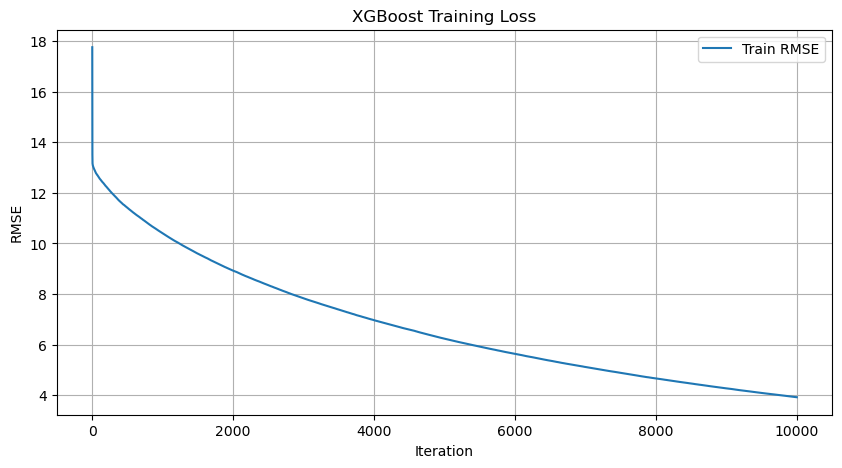

In [40]:
evals_result = model.evals_result()
train_rmse = evals_result['validation_0']['rmse']

plt.figure(figsize=(10, 5))
plt.plot(train_rmse, label="Train RMSE")
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.title("XGBoost Training Loss")
plt.legend()
plt.grid(True)
plt.show()

In [41]:
def get_test_loader(file, features, features_to_encode):
    df = pd.read_csv(file)
    def one_hot(df, feature):
        encoded = pd.get_dummies(df[[feature]])
        result = pd.concat([df, encoded], axis=1)
        result = result.drop([feature], axis=1)
        return(result) 
    df["Episode_Title"] = df["Episode_Title"].str[8:]
    df = df[features]
    imputer = SimpleImputer(strategy="median")
    df[["Episode_Length_minutes"]] = imputer.fit_transform(df[["Episode_Length_minutes"]])
    df[["Guest_Popularity_percentage"]] = imputer.fit_transform(df[["Guest_Popularity_percentage"]])
    df[["Number_of_Ads"]] = imputer.fit_transform(df[["Number_of_Ads"]])
    df["Is_Weekend"] = (df["Publication_Day"] == "Saturday") | (df["Publication_Day"] == "Sunday")
    for to_encode in features_to_encode:
        df = one_hot(df, to_encode)
    df["Ads_Per_Minute"] = df['Number_of_Ads'] / df["Episode_Length_minutes"]
    df["People_Popularity"] = df["Host_Popularity_percentage"] + df["Guest_Popularity_percentage"]
    df["Linear"] = df["Episode_Length_minutes"] * 0.728
    x = df
    x_tensor = x.to_numpy().astype(np.float32)
    return x_tensor



features=["Episode_Length_minutes", "Number_of_Ads", "Host_Popularity_percentage", "Guest_Popularity_percentage",
          "Episode_Sentiment", "Publication_Day", "Publication_Time", "Genre", "Podcast_Name" ]
features_to_encode = ["Episode_Sentiment", "Publication_Day", "Publication_Time",  "Genre", "Podcast_Name"]
test_dataloader = get_test_loader("test.csv", 
    features=features,
    features_to_encode=features_to_encode )

X_test = get_test_loader("test.csv", features, features_to_encode)

# Predict
preds = model.predict(X_test)

# Write to submission file
import csv

with open("submission_xgb.csv", "w", newline='') as f:
    writer = csv.writer(f)
    writer.writerow(["id", "prediction"])
    for i, pred in enumerate(preds, start=750000):
        writer.writerow([i, pred])


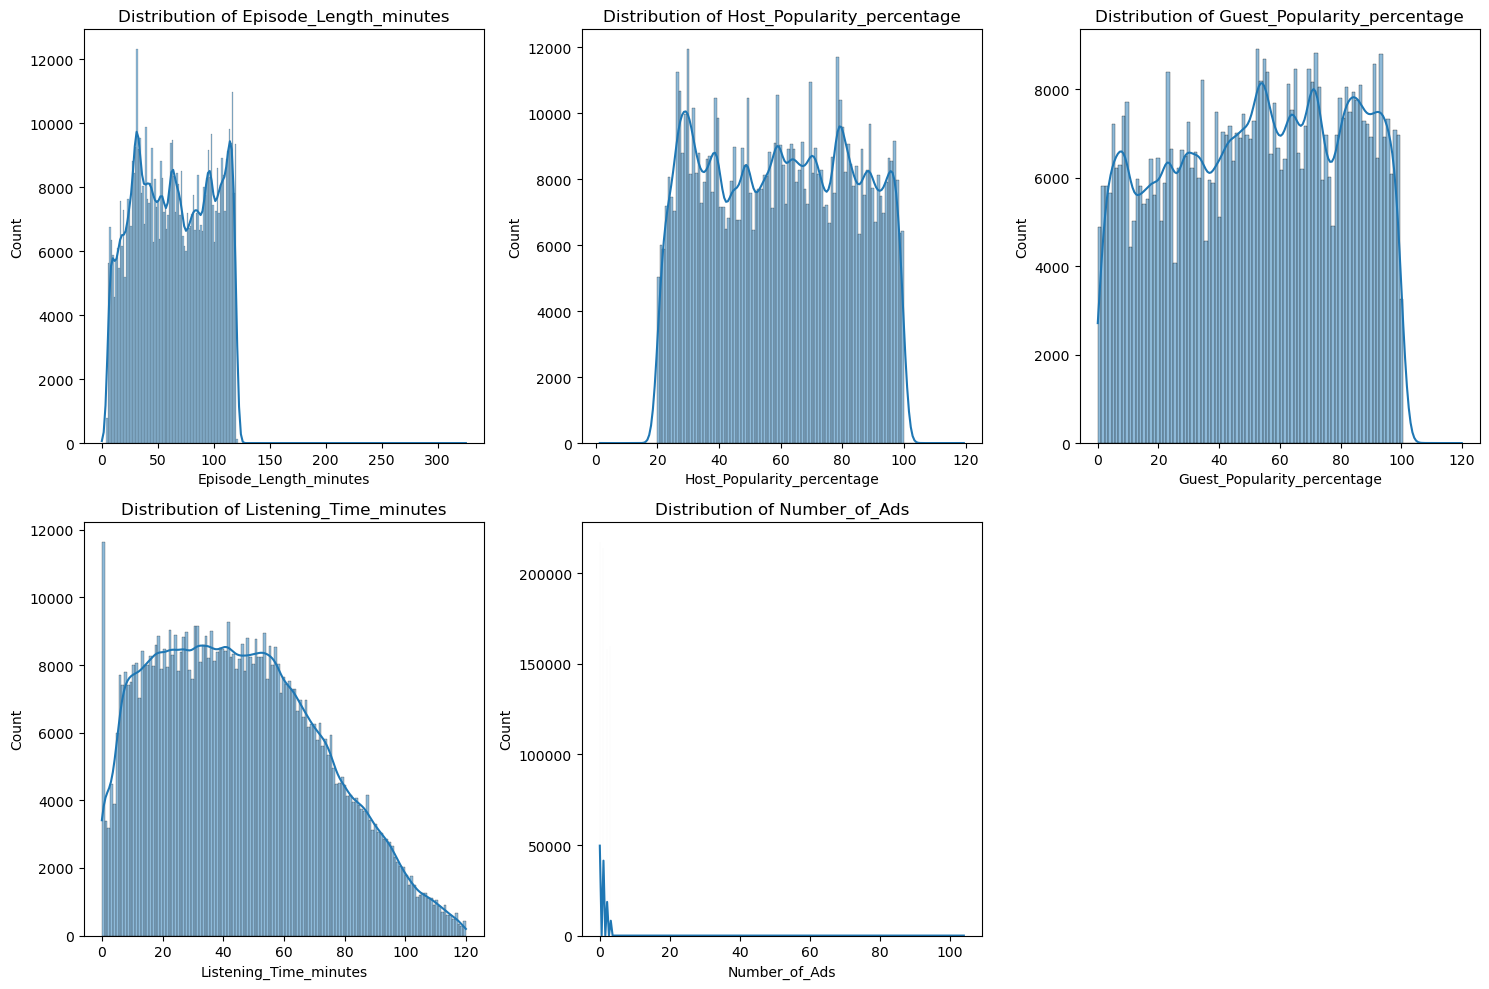

In [42]:
features_to_plot = ["Episode_Length_minutes", "Host_Popularity_percentage", 
                    "Guest_Popularity_percentage", "Listening_Time_minutes", "Number_of_Ads"]
df = pd.read_csv("train.csv")

plt.figure(figsize=(15, 10))
for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[feature], kde=True)
    plt.title(f"Distribution of {feature}")
plt.tight_layout()
plt.show()

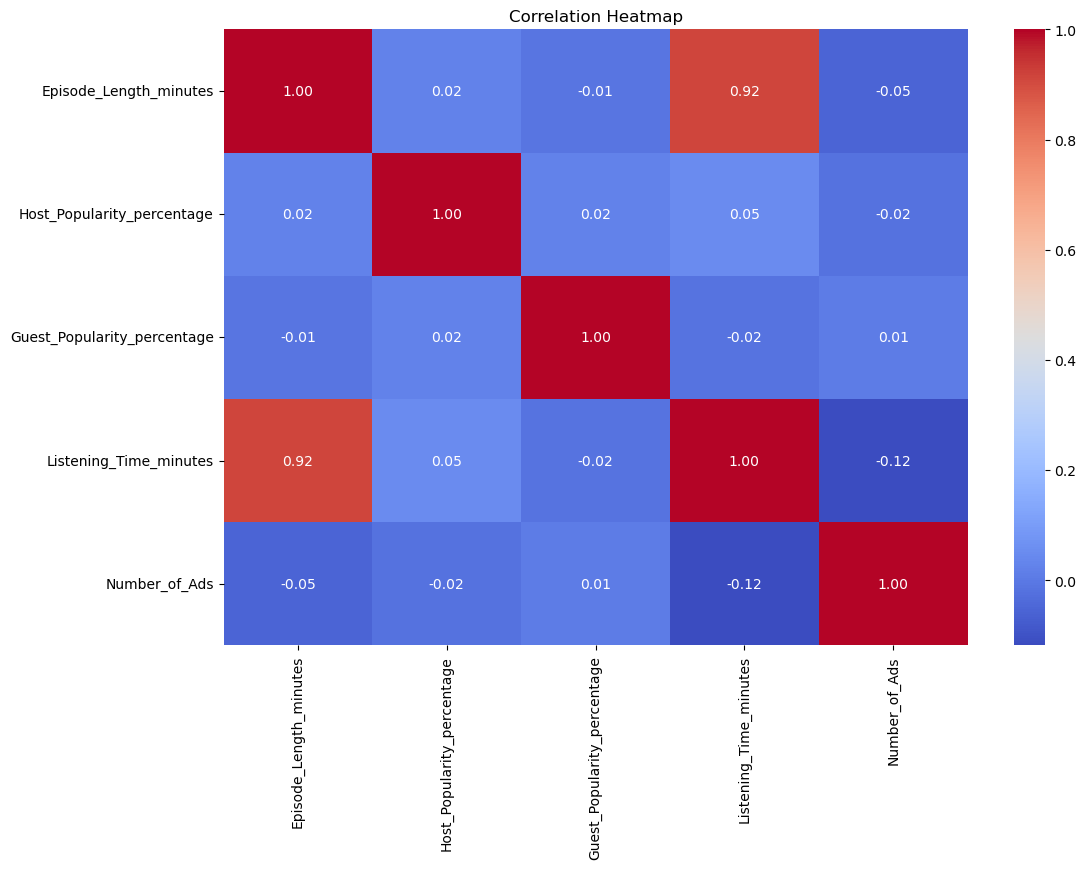

In [43]:
correlation_matrix = df[features_to_plot].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap")
plt.show()